### Generative Adversarial Networks (GAN)

GAN's is one of the important development in deep learning which was introduced in a NIPS 2014 paper by a group of researchers at the university of Montreal led by Ian Goodfellow. The GAN model are a way to have two neural netwoks  compete with each other. The generator turns random noise into immitations of the data, in an attempt to fool the adversarial or discriminator and the adversarial takes samples from generator model and training data to distinguish genuine data from forgeries created by the generator model. The GAN’s have found great appreciation in the field of image generation tasks. GAN’s real life application versatility ranges from text, image, video generation and text-to-image synthesis.

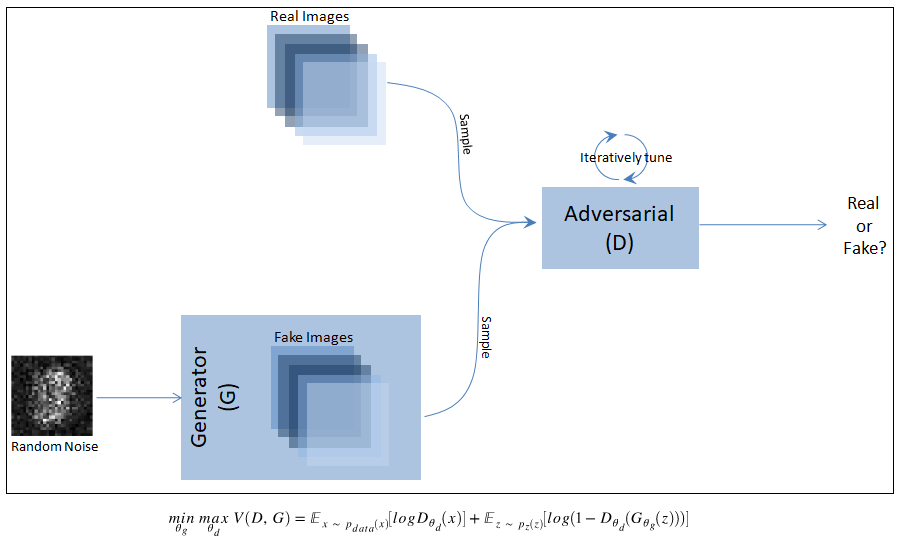

In [1]:
from IPython.display import Image
Image(filename='../Chapter 6 Figures/GANz.png', width=800)

In the above equation, training is a join minimax game, where G generates real-looking images to fool adversarial model and D tries to distinguish between real and fake images by iteratively tuning the model. Dϴd will try to maximize objective such that D(x) is close to real 1 and D(G(z)) is close to fake 0. Gϴd will try to minimize objective such that D(G(z)) is close to 1. The adversarial is fooled in to thinking generated G(z)is real.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(2017)

from keras.datasets import mnist
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from keras import initializers
from tqdm import tnrange

Using TensorFlow backend.


### Load data

In [3]:
# data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train shape: (60000, 28, 28)
X_train reshape: (60000, 784)


### Generator

In [4]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

# prints a summary representation of your model
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dens

### Adversarial or discriminator

In [5]:
# Adversarial network
adversarial = Sequential()

# Input layer and hidden layer 1
adversarial.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
adversarial.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
adversarial.add(Dense(256))
adversarial.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
adversarial.add(Dense(512))
adversarial.add(LeakyReLU(alpha=0.2))

# Output layer
adversarial.add(Dense(1, activation='sigmoid'))

# Optimizer
optimizer = Adam(lr=0.0004, beta_1=0.5)

adversarial.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# prints a summary representation of your model
adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total para

### Combined Model - Generative Adversarial Network

In [6]:
adversarial.trainable = False

gan_model = Sequential()
gan_model.add(generator)
gan_model.add(adversarial)
gan_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# prints a summary representation of your model
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 784)               583312    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 265601    
Total params: 848,913
Trainable params: 581,520
Non-trainable params: 267,393
_________________________________________________________________


In [7]:
def train(batch_size=256, train_steps=2000):
    adversarial_losses = []
    gan_losses = []
    sample_images = []
    
    for i in tnrange(train_steps):
              
        # Select a random sample from the training data
        images_train = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        
        # Create noise as input for the generator to generate the fake images
        noise = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
        images_fake = generator.predict(noise)
        
        # Create input by concatenate both real and fake images and assigning the respective labels
        input_data = np.concatenate((images_train, images_fake))
        input_labels = np.ones([2*batch_size, 1])
        input_labels[batch_size:, :] = 0
        adversarial_loss = adversarial.train_on_batch(input_data, input_labels)
           
        # Train the adversarial model to generate more realistic images
        input_labels = np.ones([batch_size, 1])
        noise = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
        gan_loss = gan_model.train_on_batch(noise, input_labels)
        
        adversarial_losses.append(adversarial_loss)
        gan_losses.append(gan_loss)

        if i % 100 == 0:
            noise = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
            fake_images = generator.predict(noise)
            sample_images.append(fake_images[0])
    
    return adversarial_losses, gan_losses, sample_images

In [8]:
adversarial_losses, gan_losses, sample_images = train()

Instructions for updating:
Use tf.cast instead.


/home/manohar/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


### Plot Evolution of Generated Images (Ones)

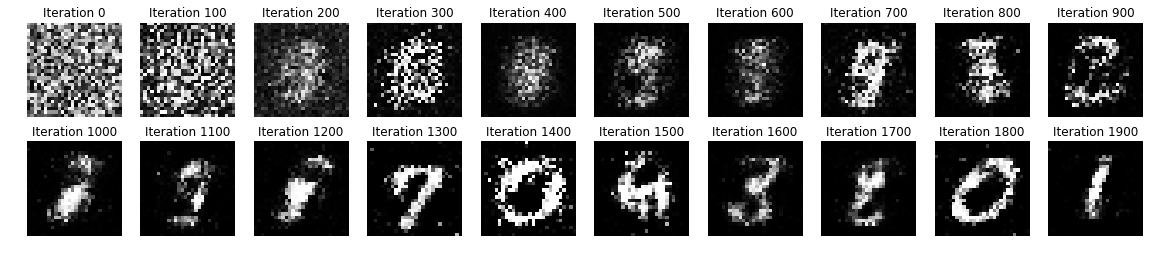

In [9]:
plt.figure(figsize=(20,4))

for i, fake_image in enumerate(sample_images, 0):
    plt.subplot(2, 10, i+1)
    plt.imshow(np.reshape(fake_image, (28, 28)), cmap='gray')
    plt.title("Iteration %d" % (i * 100))
    plt.axis('off')

### Plot Training History

Text(0.5, 1.0, 'GAN Accuracy')

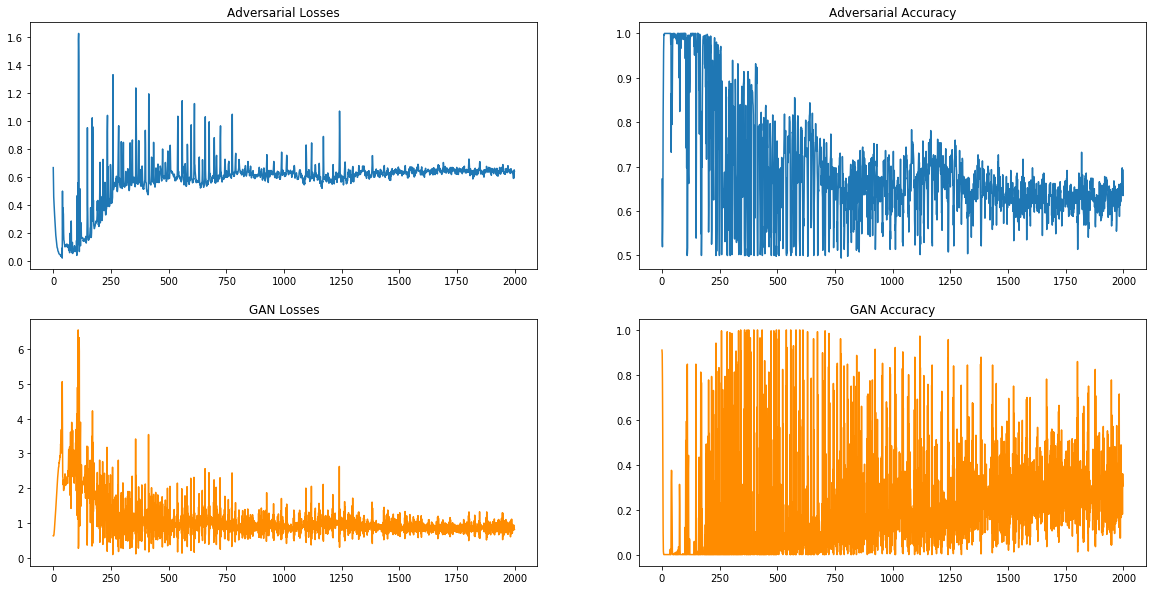

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(np.array(adversarial_losses)[:, 0])
plt.title("Adversarial Losses")

plt.subplot(2,2,2)
plt.plot(np.array(adversarial_losses)[:, 1])
plt.title("Adversarial Accuracy")

plt.subplot(2,2,3)
plt.plot(np.array(gan_losses)[:, 0], color='darkorange')
plt.title("GAN Losses")

plt.subplot(2,2,4)
plt.plot(np.array(gan_losses)[:, 1], color='darkorange')
plt.title("GAN Accuracy")

The area of GAN is growing very fast in the past couple of years. Here is link that lists various GAN versions based on research paper https://github.com/hindupuravinash/the-gan-zoo.